In [1]:
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad
from matplotlib import pyplot as plt

In [2]:
# Load Training und Val Data
with open('FormatedData/200000/x_train.pickle', 'rb') as file:
    x_train = pickle.load(file)
with open('FormatedData/200000/x_val.pickle', 'rb') as file:
    x_val = pickle.load(file)
with open('FormatedData/200000/y_train.pickle', 'rb') as file:
    y_train = pickle.load(file)
with open('FormatedData/200000/y_val.pickle', 'rb') as file:
    y_val = pickle.load(file)
print(len(x_train))
print(len(x_val))
print(len(y_train))
print(len(y_val))

190000
10000
190000
10000


In [3]:
with open('FormatedData/200000/Metadata/context_words.pickle', 'rb') as file:
    context_words = pickle.load(file)
with open('FormatedData/200000/Metadata/unique_tokens.pickle', 'rb') as file:
    unique_tokens = pickle.load(file)

In [4]:
# Metrics
def top_5_categorical_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)
def top_10_categorical_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=10)
# Activation Functions
def elliott_activation(x):
    return (0.5 * x / (1 + tf.abs(x))) + 0.5
def modified_elliott_activation(x):
    return (x / tf.sqrt(1 + tf.square(x))) + 0.5

In [5]:
dropout=.5
keras.backend.clear_session()
# Create Model
model = Sequential()
model.add(LSTM(128, input_shape=(context_words, len(unique_tokens)), return_sequences=True, recurrent_dropout=dropout,  dropout=dropout, activation="softsign"))
model.add(LSTM(128, recurrent_dropout=dropout, dropout=dropout, activation="softsign", return_sequences=True))
model.add(LSTM(128, recurrent_dropout=dropout, dropout=dropout, activation="softsign"))
model.add(Dense(len(unique_tokens), activation="softmax"))

In [6]:
# Train Model
model.compile(loss='categorical_crossentropy', optimizer=Adagrad(learning_rate=1), metrics=['accuracy', top_5_categorical_accuracy, top_10_categorical_accuracy])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128, epochs=50, shuffle=True).history

Epoch 1/50
1485/1485 [==============================] - 1175s 781ms/step - loss: 6.9618 - accuracy: 0.0519 - top_5_categorical_accuracy: 0.1589 - top_10_categorical_accuracy: 0.2275 - val_loss: 7.0800 - val_accuracy: 0.0491 - val_top_5_categorical_accuracy: 0.1260 - val_top_10_categorical_accuracy: 0.2129
Epoch 2/50
1485/1485 [==============================] - 1149s 774ms/step - loss: 6.8254 - accuracy: 0.0580 - top_5_categorical_accuracy: 0.1669 - top_10_categorical_accuracy: 0.2340 - val_loss: 7.0275 - val_accuracy: 0.0491 - val_top_5_categorical_accuracy: 0.1543 - val_top_10_categorical_accuracy: 0.2136
Epoch 3/50
1485/1485 [==============================] - 1151s 775ms/step - loss: 6.8030 - accuracy: 0.0594 - top_5_categorical_accuracy: 0.1694 - top_10_categorical_accuracy: 0.2361 - val_loss: 7.0056 - val_accuracy: 0.0491 - val_top_5_categorical_accuracy: 0.1425 - val_top_10_categorical_accuracy: 0.2139
Epoch 4/50
1485/1485 [==============================] - 1153s 776ms/step - loss

In [7]:
# Save Model and history
model.save('Models/Model11/Model_200000.h5')
pickle.dump(history, open("Models/Model11/history.p", "wb"))

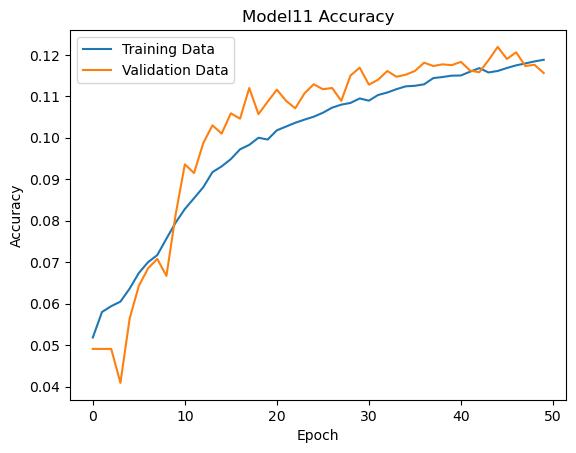

In [8]:
# Get Model stats
# model = load_model('Model11/Model_200000.h5')
history = pickle.load(open("Models/Model11/history.p", "rb"))

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model11 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Validation Data'], loc='upper left') 

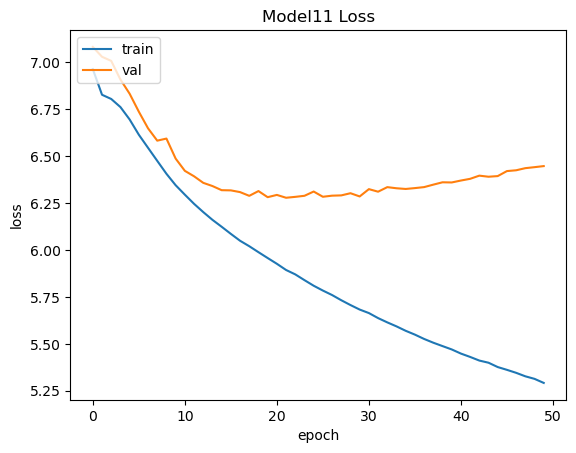

In [9]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model11 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [10]:
# Registriere die benutzerdefinierten Metrikfunktionen
custom_objects = {'top_5_categorical_accuracy': top_5_categorical_accuracy,
                  'top_10_categorical_accuracy': top_10_categorical_accuracy,
                 'elliott_activation': elliott_activation,
                 'modified_elliott_activation': modified_elliott_activation}

# Lade das Modell mit den registrierten benutzerdefinierten Metriken
with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model('Models/Model11/Model_200000.h5')